# Semantic Search in arXiv Papers

This notebook shows how to retrieve data from the arXiv API and implement semantic search and recency weighting with Superlinked. More specifically, the notebook will include the following steps:

Preparation

- Retrieving, processing and exploring the data

Setting up our vector computer

-  Creating a schema
-  Creating vector embedding spaces
-  Indexing & parsing
-  Setting up & filling an in-memory data store

Searching

- Queries
- Weighting

## Preparation

In [1]:
%%capture
%%PIP COMMAND%%
%pip install lxml bs4

### Setting up a basic logger

In [2]:
import logging
from datetime import datetime, timedelta, timezone
from urllib.parse import urlencode
import altair as alt
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup
from dateutil import parser

from superlinked import framework as sl

alt.renderers.enable("mimetype")

# Creating and configuring our logger
logging.basicConfig(filename="std.log", format="%(asctime)s %(message)s", filemode="w")
logger = logging.getLogger()

# Set the logger threshold to DEBUG if you encounter errors
logger.setLevel(logging.INFO)

## Fetching & processing data from the arXiv API

In [3]:
def query_arxiv(
    query: str = "%22large%20language%20models%22",
    max_results: int = 1000,
    order_by: str = "lastUpdatedDate",
    order: str = "descending",
) -> pd.DataFrame:
    """
    Basic function for querying the api that lets us specify the most important parameters.

    query: URL encoded string to search for in paper titles and abstracts
    max_results: maximum amount of results returned by the api
    order_by: variable to order the results by
    order: descending or ascending based on the order_by parameter
    """
    params = {
        "search_query": f"all:{query}",
        "start": 0,
        "max_results": max_results,
        "sortBy": order_by,
        "sortOrder": order,
    }
    url = f"http://export.arxiv.org/api/query?{urlencode(params)}"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        logging.info(f"Length of response text: {len(response.text)}")
        soup = BeautifulSoup(response.text, "xml")
        data = []

        for entry in soup.find_all("entry"):
            data_entry = {tag.name: tag.text.strip() for tag in entry.find_all()}
            if "id" in data_entry:  # Ensure there is an 'id' field
                data.append(data_entry)

        logging.info(f"{len(data)} entries found")
        return pd.DataFrame(data)

    except requests.exceptions.RequestException as e:
        logging.error(f"Error during request: {e}")
    except Exception as e:
        logging.error(f"Unexpected error: {e}")

    return pd.DataFrame()  # Return an empty DataFrame if there was an error

In [4]:
# We are using URL encodings here: %22 means "" and %20 stands for a space
df = query_arxiv(query="%22retrieval%20augmented%20generation%22")

In [5]:
# Notice that we set the maximum to 1000 but the api returned less results, meaning
# that the number of paper titles and abstracts including our search query is below 1000
len(df)

372

## Exploring & preparing the data

In [6]:
# Checking all columns
df.columns

sl.Index(['id', 'updated', 'published', 'title', 'summary', 'author', 'name',
       'link', 'primary_category', 'category', 'comment', 'journal_ref', 'doi',
       'affiliation'],
      dtype='object')

In [7]:
# Feel free to play around more with the data if you want,
# but for this application, we will only need a few columns
df = df[["id", "published", "title", "summary"]].copy()

In [8]:
df.head(3)

,id,published,title,summary
0,http://arxiv.org/abs/2405.14831v1,2024-05-23T17:47:55Z,HippoRAG: Neurobiologically Inspired Long-Term...,In order to thrive in hostile and ever-changin...
1,http://arxiv.org/abs/2405.14702v1,2024-05-23T15:37:06Z,G3: An Effective and Adaptive Framework for Wo...,Worldwide geolocalization aims to locate the p...
2,http://arxiv.org/abs/2405.14431v1,2024-05-23T11:00:19Z,RaFe: Ranking Feedback Improves Query Rewritin...,As Large Language Models (LLMs) and Retrieval ...


In [9]:
# Renaming the columns to have more intuitive names
df = df.reset_index().rename(columns={"id": "url", "index": "id", "summary": "abstract"})

In [10]:
# The api returns the datetimes as a string, which we first parse
# in the datetime format and then convert them to timestamps
df["published_timestamp"] = [int(parser.parse(date).replace(tzinfo=timezone.utc).timestamp()) for date in df.published]

## Visualizing the timestamps

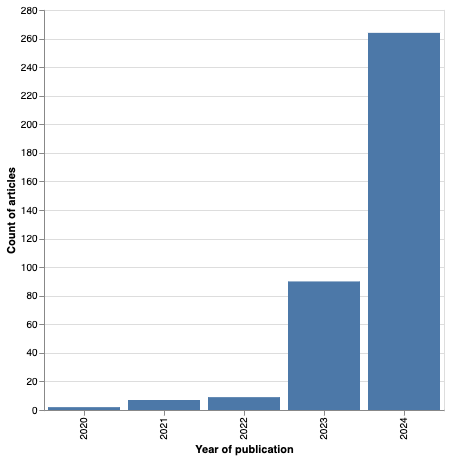

In [11]:
# some quick transformations and an altair histogram
years_to_plot: pd.DataFrame = pd.DataFrame(
    {"year_of_publication": [int(datetime.fromtimestamp(ts).year) for ts in df["published_timestamp"]]}
)
alt.Chart(years_to_plot).mark_bar().encode(
    x=alt.X("year_of_publication:N", title="Year of publication"),
    y=alt.Y("count()", title="Count of articles"),
).properties(width=400, height=400)

## Setting up Superlinked

In [12]:
# Setting up the schema according to our inputs
class PapersSchema(sl.Schema):
    url: sl.String
    title: sl.String
    abstract: sl.String
    published_timestamp: sl.Timestamp
    id: sl.IdField


papers = PapersSchema()

In [13]:
YEAR_IN_DAYS = 365

# Textual characteristics are embedded using a sentence-transformers model
abstract_space = sl.TextSimilaritySpace(text=papers.abstract, model="sentence-transformers/all-mpnet-base-v2")
title_space = sl.TextSimilaritySpace(text=papers.title, model="sentence-transformers/all-mpnet-base-v2")
# Release date is encoded using Superlinked's recency embedding algorithm
recency_space = sl.RecencySpace(
    timestamp=papers.published_timestamp,
    period_time_list=[
        sl.PeriodTime(timedelta(days=0.5 * YEAR_IN_DAYS), weight=1),
        sl.PeriodTime(timedelta(days=10 * YEAR_IN_DAYS), weight=1),
    ],
    negative_filter=0.0,
)

In [14]:
# We create an index of our spaces
papers_index = sl.Index(spaces=[abstract_space, title_space, recency_space])

In [15]:
dataframe_parser = sl.DataFrameParser(
    schema=papers,
    mapping={
        papers.published_timestamp: "published_timestamp",
        papers.abstract: "abstract",
    },
)

In [16]:
# Setting a specific end date to ensure reproducibility of the notebook
END_OF_APRIL_24_TS = int(datetime(2024, 4, 30, 23, 59).timestamp())
EXECUTOR_DATA = {sl.CONTEXT_COMMON: {sl.CONTEXT_COMMON_NOW: END_OF_APRIL_24_TS}}

source: sl.InMemorySource = sl.InMemorySource(papers, parser=dataframe_parser)
executor: sl.InMemoryExecutor = sl.InMemoryExecutor(
    sources=[source], indices=[papers_index], context_data=EXECUTOR_DATA
)
app: sl.InMemoryApp = executor.run()

In [17]:
# IMPORTANT: if you're running this notebook in Google Colab and
# this step is taking very long - you might be running an instance without a GPU
source.put([df])

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

## Understanding recency

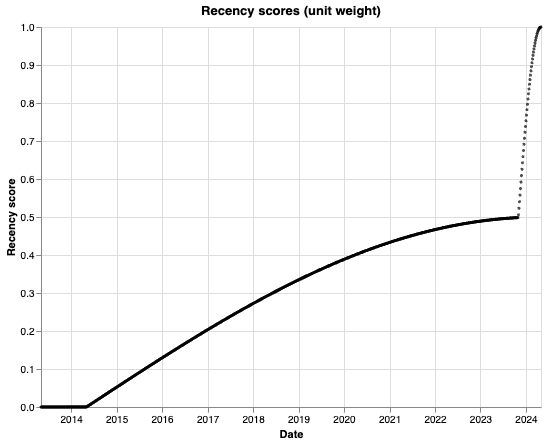

In [18]:
# To get an intuitive understanding of how recency is weighted for our data,
# we can explore the weights using Superlinked's inbuilt RecencyPlotter
recency_plotter = sl.RecencyPlotter(recency_space, context_data=EXECUTOR_DATA)
recency_plotter.plot_recency_curve()

## Defining queries

In [19]:
TOP_N = 10

# A simple query will serve us right when we simply want to search the dataset with a search term
# the term will search in both textual fields
# and we will have the option to weight certain inputs' importance
simple_query = (
    sl.Query(
        papers_index,
        weights={
            abstract_space: sl.Param("abstract_weight"),
            title_space: sl.Param("title_weight"),
            recency_space: sl.Param("recency_weight"),
        },
    )
    .find(papers)
    .similar(abstract_space, sl.Param("query_text"))
    .similar(title_space, sl.Param("query_text"))
    .select(papers.abstract, papers.title, papers.published_timestamp)
    .limit(TOP_N)
)

## Executing the queries

In [21]:
regular_result = app.query(
    simple_query,
    query_text="cost reduction",
    abstract_weight=1,
    title_weight=1,
    recency_weight=0,
)

df = sl.PandasConverter.to_pandas(regular_result)
sl.PandasConverter.format_date_column(df, "published_timestamp", "release_date")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,abstract,title,release_date,id
0,By integrating Artificial Intelligence (AI) wi...,Generative AI for Low-Carbon Artificial Intell...,2024-04-28,69
1,"In this paper, we explore the potential applic...",Automated Conversion of Static to Dynamic Sche...,2024-05-08,44
2,Design/methodology/approach This research eval...,Graph database while computationally efficient...,2024-01-15,287
3,Standard Full-Data classifiers in NLP demand t...,Making LLMs Worth Every Penny: Resource-Limite...,2023-11-10,327
4,There is a compelling necessity from enterpris...,Fine Tuning LLM for Enterprise: Practical Guid...,2024-03-23,163
5,The task of converting natural language querie...,DFIN-SQL: Integrating Focused Schema with DIN-...,2024-03-01,203
6,As Large Language Models (LLMs) and Retrieval ...,RaFe: Ranking Feedback Improves Query Rewritin...,2024-05-23,2
7,The interest in updating Large Language Models...,LLMs Instruct LLMs:An Extraction and Editing M...,2024-03-23,164
8,"In customer service technical support, swiftly...",Retrieval-Augmented Generation with Knowledge ...,2024-04-26,50
9,In the rapidly evolving field of assistive tec...,Towards Standards-Compliant Assistive Technolo...,2024-04-04,138


In [22]:
recency_weighted_result = app.query(
    simple_query,
    query_text="cost reduction",
    abstract_weight=1,
    title_weight=1,
    recency_weight=5,
)

df = sl.PandasConverter.to_pandas(recency_weighted_result)
sl.PandasConverter.format_date_column(df, "published_timestamp", "release_date")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,abstract,title,release_date,id
0,By integrating Artificial Intelligence (AI) wi...,Generative AI for Low-Carbon Artificial Intell...,2024-04-28,69
1,"In this paper, we explore the potential applic...",Automated Conversion of Static to Dynamic Sche...,2024-05-08,44
2,As Large Language Models (LLMs) and Retrieval ...,RaFe: Ranking Feedback Improves Query Rewritin...,2024-05-23,2
3,Purpose: The purpose of this study is to inves...,Exploring the Potential of Large Language Mode...,2024-05-15,24
4,"In customer service technical support, swiftly...",Retrieval-Augmented Generation with Knowledge ...,2024-04-26,50
5,Accurate evaluation of financial question answ...,FinTextQA: A Dataset for Long-form Financial Q...,2024-05-16,22
6,"This paper introduces xRAG, an innovative cont...",xRAG: Extreme Context Compression for Retrieva...,2024-05-22,4
7,Large Language Models (LLMs) have made signifi...,Compressing Long Context for Enhancing RAG wit...,2024-05-06,53
8,Enterprise retrieval augmented generation (RAG...,Question-Based Retrieval using Atomic Units fo...,2024-05-20,12
9,This paper introduces the RAG-RLRC-LaySum fram...,RAG-RLRC-LaySum at BioLaySumm: Integrating Ret...,2024-05-21,8


In [23]:
# A quick helper to visualize the effect of recency weighting
def get_time_differences(result: sl.QueryResult, alternative_result: sl.QueryResult) -> list[float]:
    # Getting the timestamps of both results
    result_ts = [entry.fields["published_timestamp"] for entry in result.entries]
    alternative_result_ts = [entry.fields["published_timestamp"] for entry in alternative_result.entries]
    # Calculating the absolute time difference in seconds
    time_diff = list(np.absolute(np.array(result_ts) - np.array(alternative_result_ts)))
    # Rounded time difference in days
    time_diff_days = [round(t_d / 3600 / 24, 1) for t_d in time_diff]
    return time_diff_days

In [24]:
get_time_differences(regular_result, recency_weighted_result)

[0.0, 0.0, 129.2, 186.7, 34.4, 76.2, 0.8, 43.8, 23.9, 47.8]

You will see that a lot of the positions haven’t changed, but some have!

Obviously, this was a pretty basic example. But I hope I was able to make clear why recency can be an important factor. We could’ve also filtered our timestamp data - metadata filtering is a common practice in Advanced RAG systems after all. However, the recency embeddings we used here are generally more nuanced, similar to how text embeddings are more nuanced than regex.

Which one will work better for you will depend on your specific use case. It’s important to remember that there are no silver bullets!